Рекуррентные и свёрточные нейрононные сети и embeddings для работы с текстом.

Датасет - Руcскоязычные отзывы с оценками.

Метрика - на ваше усмотрение

Задачи:

- Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. Посмотреть на важность для каждой оценки.
- Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.
- Обучить «fasttext» модель на n-граммах используя случайную инициализацию эмбедингов. 
- Обучить сharacter based модель (вместо слов мы подаём предложение посимвольно). 
    Заимплементить самому, либо нагуглить готовые имплементации.
- Опционально (for honor): Обучить модель из примера имплементации ниже, но с использованием уже предобученного word2vec для русского языка. в качестве инициализации эмбединга.

Сравнить качество моделей, сделать выводы
Почитать про слои которые используются для решения этого задания.

In [1]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade seaborn
!pip install --upgrade pprint
!pip install --upgrade tensorflow
!pip install --upgrade pymystem3
#!pip install --upgrade contractions
#!pip install --upgrade wordcloud
#!pip install --upgrade umap-learn
!pip install --upgrade gensim
#!pip install --upgrade pyldavis

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.1)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.12.0)
Requirement already up-to-date: pymystem3 in c:\anaconda\lib\site-packages (0.2.0)
Requirement already up-to-date: gensim in c:\anaconda\lib\site-packages (3.7.1)


In [2]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
from time import time
from itertools import compress
from collections import Counter
#import glob
#import contractions
#from wordcloud import WordCloud
#import umap
#import unicodedata
#from bs4 import BeautifulSoup

#import time

#from scipy import interp

import pickle
sns.set(font_scale=1.3)

seed = 321

%matplotlib inline

In [3]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report,f1_score, make_scorer

from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [4]:
import sys
import requests
import gensim
from pymystem3 import Mystem

In [5]:
import tensorflow as tf

import keras
import json
import operator
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional, GlobalAveragePooling1D,Flatten,BatchNormalization
from keras.metrics import binary_accuracy,categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import np_utils

#convert words to sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.datasets import imdb

Using TensorFlow backend.


In [6]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [7]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

#### EDA.

read first ten row to understand, how to parse data.

In [8]:
x_data, y_data = pickle.load(open('data/task_2/reviews_dataset.pkl', 'rb'))

In [9]:
len(x_data)

769251

In [10]:
len(y_data)

769251

In [11]:
x_data[0]

'Потрясающе красивая графика космоса! Уже за это игру можно полюбить. Так же в наличии интересный осмысленный сюжет и удобное управление.'

In [12]:
y_data[0]

5

Baseline.

Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. 

Посмотреть на важность для каждой оценки.

In [13]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)    
    return text


#version on raw text
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('\n', ' ',text)
    new_text = re.sub('\t', '',new_text)
    new_text = re.sub('['+text_punctuation+']', ' ',new_text)
    new_text =  new_text.strip()
    
    return new_text

#version after word_tokenizer
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text


#ntlk word lemmatizer
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='n') # v default
        new_text_lemma.append(lemma)
        
        #stemm = stemmer.stem(word)
        #new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

StopWords = list(set(stopwords.words('russian')))
'''
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie','sza']

#StopWords.extend(newStopWords)
#StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))
# temporaly disabled to reduce tfidf time
#StopWords.extend(Common_First_Names) ''';

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text


# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    # text to lowercase
    text =  text.lower()

    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 

    # tokenize text
    words = word_tokenize(text,language='english')

       
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words ,improve to 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 2) #default 3

    return words

In [14]:
%%time
test = tokenize(x_data[4])

Wall time: 9.97 ms


In [15]:
test

['таки',
 'удержался',
 'написать',
 'топ',
 'скорей',
 'сотрут',
 'прочтет',
 'ужасной',
 'игры',
 'star',
 'war',
 'empire',
 'at',
 'war',
 'dvd',
 'ещё',
 'поискать',
 'нормального',
 'сюжета',
 'стратегия',
 'это',
 'вовсе',
 'провал',
 'давно',
 'убедился',
 'всё',
 'берётся',
 '1с',
 'плане',
 'игр',
 'отстой',
 'хорошая',
 'стратегия',
 'эпизодам',
 'star',
 'war',
 'это',
 'star',
 'war',
 'galactic',
 'battleground',
 'играл',
 'поймет']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, test_size=0.3, shuffle=True)

#### TFIDF + LogisticRegression.

In [43]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             min_df=4, # ignore terms with freq less that т, lower majoring 4
                             max_df=0.8, # ignore terms with freq more that n, upper majoring 0.8
                             #max_features=100000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             #ngram_range= (1, 3) # также используем н-граммы
                            )

In [44]:
%%time
vectorised_train_documents = vectorizer.fit_transform(x_train)
vectorised_test_documents = vectorizer.transform(x_test)

In [45]:
vectorised_train_documents.shape

(538475, 143312)

In [46]:
vectorised_test_documents.shape

(230776, 143312)

In [57]:
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [54]:
log_reg = LogisticRegression(penalty='l2', tol=0.0001, C=1, 
                             class_weight='balanced', random_state=seed, 
                             max_iter=1000, solver = 'newton-cg',
                             multi_class='ovr', verbose=0, 
                             n_jobs=-1)

In [55]:
%%time
_,_, clf = classify_and_score(log_reg, vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)

Wall time: 1min 45s


              precision    recall  f1-score   support

           1       0.41      0.57      0.48     16683
           2       0.16      0.22      0.19      9679
           3       0.24      0.34      0.28     17653
           4       0.34      0.41      0.37     33086
           5       0.89      0.76      0.82    153675

   micro avg       0.64      0.64      0.64    230776
   macro avg       0.41      0.46      0.43    230776
weighted avg       0.70      0.64      0.66    230776

Confusion matrix, without normalization
None


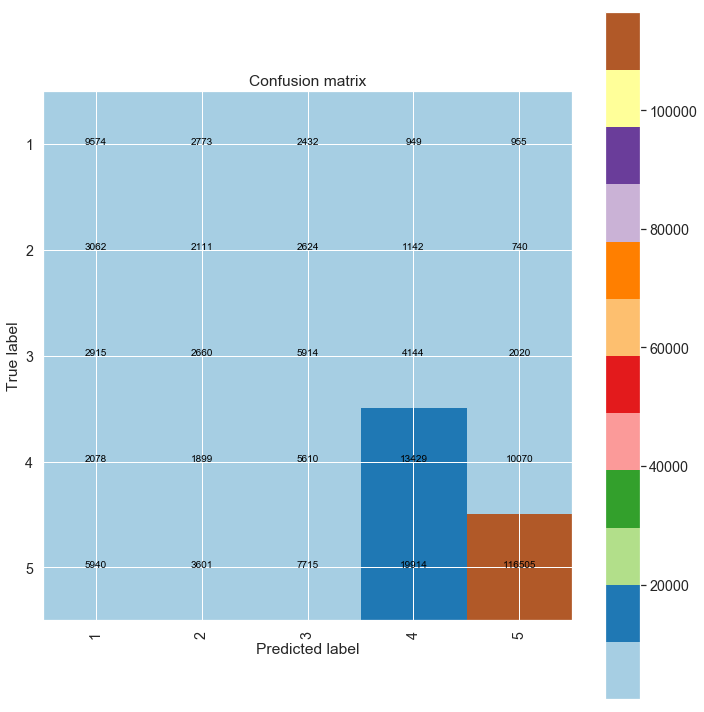

In [58]:
labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.

- add stopwords?

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, 
                                                    test_size=0.3, shuffle=True,
                                                    stratify = y_data)

In [47]:
# Set parameters:
num_word = 15000
max_features = 20000
batch_size = 128
embedding_dims = 128
epochs = 3
maxlen = 80

In [48]:
%%time
tokenizer = Tokenizer(num_words=num_word)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print (vocab_size)

485401
Wall time: 1min 45s


In [49]:
#len(x_train)

In [50]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [37]:
#y_train = np.array(y_train)
#y_test = np.array(y_test)

print (vocab_size)

print(x_train[0])

print(len(x_train[0]))

print(len(x_train))

In [51]:
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [39]:
print(x_train[0])

[ 6579   365     7 14591     1  2034    15  7231  2724    11    28    20
  3633    39     1   548    13    80     4  6272  3817  7044  8109    11
  1967  1093  3690    19     6  2560     1     2  1696  6620   828     1
    39     5 12961     9  4132  4398  7125     3     7  6858 12318  3059
  1786     7 12318  3059     2     4  3784   102  3817   665  1525  3729
     6    33    14 13308  1708     7 12318  3059   879  4643     7  2726
    10    54 10758    15   283 14297   558  3611]


In [57]:
vocab_size * 128 # params of first layer, 128 is number of embeddings

62131328

In [53]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 128, 
                    input_length=maxlen))#weights!
model.add(Bidirectional(LSTM(64)))# weights!
model.add(Dropout(0.1))
#model.add(Dropout(0.5)) #1
model.add(Dense(5, activation='softmax')) #softmax due to multiclass
earlyStopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2, mode='max',restore_best_weights=True)

# try using different optimizers and different optimizer configs
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 128)           62131328  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 62,230,789
Trainable params: 62,230,789
Non-trainable params: 0
_________________________________________________________________


In [54]:
# no stratify
x_train_part,y_train_part = next_batch(15000, x_train, y_train)
x_test_part,y_test_part = next_batch(5000, x_test, y_test)

In [55]:
%%time
print('Train...')
model.fit(x_train_part, y_train_part,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 2,
          callbacks=[earlyStopping],
          validation_data=[x_test_part, y_test_part])

Train...
Train on 15000 samples, validate on 5000 samples
Epoch 1/3
 - 219s - loss: 1.0673 - acc: 0.6558 - val_loss: 0.9358 - val_acc: 0.6658
Epoch 2/3
 - 214s - loss: 0.8162 - acc: 0.6897 - val_loss: 0.9086 - val_acc: 0.6704
Epoch 3/3
 - 221s - loss: 0.6613 - acc: 0.7504 - val_loss: 0.9878 - val_acc: 0.6750
Wall time: 10min 57s


In [56]:
y_predicted_scores = model.predict(x_test_part)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test_part, y_predicted_scores))

Classification report



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.64      0.11      0.19       369
           1       0.00      0.00      0.00       206
           2       0.00      0.00      0.00       384
           3       0.41      0.11      0.17       717
           4       0.81      0.86      0.83      3324

   micro avg       0.78      0.60      0.68      5000
   macro avg       0.37      0.22      0.24      5000
weighted avg       0.64      0.60      0.59      5000
 samples avg       0.60      0.60      0.60      5000



#### fasttext.

Обучить «fasttext» модель на n-граммах используя случайную инициализацию эмбедингов.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, 
                                                    test_size=0.3, shuffle=True,
                                                    stratify = y_data)

In [173]:
# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 250
batch_size = 128
embedding_dims = 64
epochs = 4

In [29]:
%%time
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Wall time: 1min 49s


In [175]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [176]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

In [177]:
def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [178]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

Adding 2-gram features
Average train sequence length: 54
Average test sequence length: 52


In [179]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, padding='post', maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (538475, 250)
x_test shape: (230776, 250)


In [180]:
vocab_size = x_train.max()#len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [181]:
x_train_part,y_train_part = next_batch(25000, x_train, y_train)
x_test_part,y_test_part = next_batch(11000, x_test, y_test)

In [29]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9)

In [190]:
print('Build model...')
model = Sequential()



# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
# используя случайную инициализацию эмбедингов
model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dims,
                    input_length=maxlen, 
                    embeddings_initializer = 'RandomNormal')) 

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a softmax:
model.add(Dense(5, activation='softmax'))

earlyStopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2, mode='max',restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
              optimizer = sgd,
              #optimizer='adam',
              metrics=['accuracy'])

#model.compile(loss='mse', optimizer=TFOptimizer(tf.train.GradientDescentOptimizer(0.1)))



model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 64)           132820032 
_________________________________________________________________
global_average_pooling1d_7 ( (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 132,820,357
Trainable params: 132,820,357
Non-trainable params: 0
_________________________________________________________________


In [191]:
model.fit(x_train_part, y_train_part,
          batch_size=batch_size,
          epochs=3, #epochs
          callbacks=[earlyStopping],
          validation_data=(x_test_part, y_test_part))

C:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 132820032 elements. This may consume a large amount of memory.
  num_elements)


Train on 25000 samples, validate on 11000 samples
Epoch 1/2
25000/25000 [==============================] - ETA: 27:38 - loss: 1.6295 - acc: 0.05 - ETA: 16:07 - loss: 1.6277 - acc: 0.05 - ETA: 12:16 - loss: 1.6247 - acc: 0.05 - ETA: 10:15 - loss: 1.6185 - acc: 0.04 - ETA: 9:03 - loss: 1.6122 - acc: 0.0797 - ETA: 8:10 - loss: 1.6034 - acc: 0.181 - ETA: 7:32 - loss: 1.5934 - acc: 0.248 - ETA: 7:03 - loss: 1.5849 - acc: 0.293 - ETA: 6:41 - loss: 1.5754 - acc: 0.327 - ETA: 6:22 - loss: 1.5626 - acc: 0.362 - ETA: 6:07 - loss: 1.5487 - acc: 0.393 - ETA: 5:54 - loss: 1.5347 - acc: 0.418 - ETA: 5:43 - loss: 1.5221 - acc: 0.437 - ETA: 5:34 - loss: 1.5129 - acc: 0.448 - ETA: 5:24 - loss: 1.4980 - acc: 0.465 - ETA: 5:17 - loss: 1.4860 - acc: 0.476 - ETA: 5:10 - loss: 1.4759 - acc: 0.483 - ETA: 5:04 - loss: 1.4647 - acc: 0.491 - ETA: 4:58 - loss: 1.4511 - acc: 0.501 - ETA: 4:53 - loss: 1.4372 - acc: 0.511 - ETA: 4:48 - loss: 1.4228 - acc: 0.520 - ETA: 4:44 - loss: 1.4090 - acc: 0.529 - ETA: 4:39 - 

In [192]:
y_predicted_scores = model.predict(x_test_part)

In [193]:
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test_part, y_predicted_scores))

Classification report



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       777
           1       0.00      0.00      0.00       490
           2       0.00      0.00      0.00       906
           3       0.00      0.00      0.00      1561
           4       0.66      0.98      0.79      7266

   micro avg       0.66      0.65      0.65     11000
   macro avg       0.13      0.20      0.16     11000
weighted avg       0.44      0.65      0.52     11000
 samples avg       0.65      0.65      0.65     11000



Обучить сharacter based модель (вместо слов мы подаём предложение посимвольно).

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, 
                                                    test_size=0.3, shuffle=True,
                                                    stratify = y_data)

In [209]:
max_features = 20000
maxlen = 400
batch_size = 64
embedding_dims = 64
epochs = 4

In [210]:
%%time
tokenizer = Tokenizer(
    char_level=True,
    #filters=None,
    lower=True,
    num_words=max_features
)

tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Wall time: 2min 37s


In [211]:
%%time
x_train = sequence.pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, padding='post', maxlen=maxlen)

Wall time: 28.3 s


In [212]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [221]:
x_train.shape

(538475, 400)

In [222]:
y_train.shape

(538475, 5)

In [245]:
x_train_part,y_train_part = next_batch(100000, x_train, y_train)
x_test_part,y_test_part = next_batch(33000, x_test, y_test)

In [246]:
x_train_part.shape

(100000, 400)

In [247]:
y_train_part.shape

(100000, 5)

- Samples. One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps. One time step is one point of observation in the sample.
- Features. One feature is one observation at a time step.

so, we have x_train_part.shape[0] samples, 1 time step and maxlen = x_train_part.shape[1] features.

In [248]:
x_train_part = np.reshape(x_train_part, (x_train_part.shape[0], 1,  x_train_part.shape[1]))
x_test_part = np.reshape(x_test_part, ( x_test_part.shape[0], 1,  x_test_part.shape[1]))

In [249]:
x_train_part.shape

(100000, 1, 400)

In [251]:
# define model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train_part.shape[1], x_train_part.shape[2]), activation="tanh", return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, input_shape=(500, 25000), activation="tanh", return_sequences=False))
#model.add(Dropout(0.1))
model.add(Dense(32, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(5, activation="softmax"))

earlyStopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2, mode='max',restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
              #optimizer = sgd,
              optimizer='adam',
              metrics=['accuracy'])

#model.summary()

model.fit(x_train_part, y_train_part,
          batch_size=batch_size,
          epochs=4, #epochs
          callbacks=[earlyStopping],
          validation_data=(x_test_part, y_test_part))

Train on 100000 samples, validate on 33000 samples
Epoch 1/4
 46080/100000 [============>.................] - ETA: 2:03:36 - loss: 1.8717 - acc: 0.20 - ETA: 31:16 - loss: 1.8974 - acc: 0.2109 - ETA: 18:01 - loss: 1.8694 - acc: 0.24 - ETA: 12:43 - loss: 1.8526 - acc: 0.25 - ETA: 9:10 - loss: 1.8510 - acc: 0.2433 - ETA: 7:37 - loss: 1.8474 - acc: 0.242 - ETA: 6:32 - loss: 1.8379 - acc: 0.239 - ETA: 5:44 - loss: 1.8340 - acc: 0.237 - ETA: 4:55 - loss: 1.8136 - acc: 0.249 - ETA: 4:28 - loss: 1.8015 - acc: 0.253 - ETA: 3:59 - loss: 1.7810 - acc: 0.259 - ETA: 3:41 - loss: 1.7698 - acc: 0.263 - ETA: 3:26 - loss: 1.7670 - acc: 0.261 - ETA: 3:09 - loss: 1.7524 - acc: 0.266 - ETA: 2:55 - loss: 1.7445 - acc: 0.270 - ETA: 2:43 - loss: 1.7244 - acc: 0.282 - ETA: 2:32 - loss: 1.7111 - acc: 0.290 - ETA: 2:23 - loss: 1.6929 - acc: 0.299 - ETA: 2:15 - loss: 1.6800 - acc: 0.307 - ETA: 2:10 - loss: 1.6683 - acc: 0.314 - ETA: 2:04 - loss: 1.6569 - acc: 0.320 - ETA: 1:58 - loss: 1.6424 - acc: 0.328 - ETA: 

 47552/100000 [=============>................] - ETA: 35s - loss: 1.2555 - acc: 0.60 - ETA: 28s - loss: 1.1638 - acc: 0.63 - ETA: 28s - loss: 1.1223 - acc: 0.64 - ETA: 28s - loss: 1.1111 - acc: 0.64 - ETA: 28s - loss: 1.0889 - acc: 0.65 - ETA: 28s - loss: 1.0926 - acc: 0.65 - ETA: 28s - loss: 1.1028 - acc: 0.65 - ETA: 27s - loss: 1.0959 - acc: 0.65 - ETA: 28s - loss: 1.0919 - acc: 0.65 - ETA: 28s - loss: 1.0815 - acc: 0.66 - ETA: 28s - loss: 1.0899 - acc: 0.65 - ETA: 28s - loss: 1.0931 - acc: 0.65 - ETA: 27s - loss: 1.0972 - acc: 0.65 - ETA: 27s - loss: 1.0971 - acc: 0.65 - ETA: 26s - loss: 1.0971 - acc: 0.65 - ETA: 27s - loss: 1.0937 - acc: 0.65 - ETA: 26s - loss: 1.0931 - acc: 0.65 - ETA: 26s - loss: 1.0938 - acc: 0.65 - ETA: 26s - loss: 1.0957 - acc: 0.65 - ETA: 26s - loss: 1.0941 - acc: 0.65 - ETA: 26s - loss: 1.0971 - acc: 0.65 - ETA: 26s - loss: 1.0951 - acc: 0.65 - ETA: 26s - loss: 1.0951 - acc: 0.65 - ETA: 26s - loss: 1.0932 - acc: 0.65 - ETA: 26s - loss: 1.0901 - acc: 0.65 - E

100000/100000 [==============================] - ETA: 3s - loss: 1.0764 - acc: 0.663 - ETA: 2s - loss: 1.0766 - acc: 0.662 - ETA: 2s - loss: 1.0764 - acc: 0.663 - ETA: 2s - loss: 1.0764 - acc: 0.663 - ETA: 2s - loss: 1.0765 - acc: 0.663 - ETA: 2s - loss: 1.0766 - acc: 0.662 - ETA: 2s - loss: 1.0766 - acc: 0.662 - ETA: 2s - loss: 1.0766 - acc: 0.662 - ETA: 2s - loss: 1.0764 - acc: 0.663 - ETA: 2s - loss: 1.0763 - acc: 0.663 - ETA: 2s - loss: 1.0765 - acc: 0.662 - ETA: 2s - loss: 1.0764 - acc: 0.662 - ETA: 2s - loss: 1.0764 - acc: 0.662 - ETA: 2s - loss: 1.0763 - acc: 0.663 - ETA: 2s - loss: 1.0761 - acc: 0.663 - ETA: 2s - loss: 1.0765 - acc: 0.662 - ETA: 2s - loss: 1.0766 - acc: 0.662 - ETA: 2s - loss: 1.0768 - acc: 0.662 - ETA: 2s - loss: 1.0770 - acc: 0.662 - ETA: 1s - loss: 1.0772 - acc: 0.662 - ETA: 1s - loss: 1.0769 - acc: 0.662 - ETA: 1s - loss: 1.0770 - acc: 0.662 - ETA: 1s - loss: 1.0770 - acc: 0.662 - ETA: 1s - loss: 1.0768 - acc: 0.662 - ETA: 1s - loss: 1.0771 - acc: 0.662 - E

 31744/100000 [========>.....................] - ETA: 1:02 - loss: 0.9684 - acc: 0.718 - ETA: 56s - loss: 1.0168 - acc: 0.703 - ETA: 45s - loss: 1.0438 - acc: 0.67 - ETA: 53s - loss: 1.0497 - acc: 0.67 - ETA: 47s - loss: 1.0551 - acc: 0.67 - ETA: 47s - loss: 1.0440 - acc: 0.67 - ETA: 46s - loss: 1.0472 - acc: 0.67 - ETA: 47s - loss: 1.0350 - acc: 0.68 - ETA: 45s - loss: 1.0558 - acc: 0.67 - ETA: 45s - loss: 1.0590 - acc: 0.67 - ETA: 45s - loss: 1.0647 - acc: 0.66 - ETA: 43s - loss: 1.0584 - acc: 0.67 - ETA: 43s - loss: 1.0609 - acc: 0.67 - ETA: 43s - loss: 1.0635 - acc: 0.66 - ETA: 43s - loss: 1.0731 - acc: 0.66 - ETA: 43s - loss: 1.0693 - acc: 0.66 - ETA: 44s - loss: 1.0784 - acc: 0.66 - ETA: 44s - loss: 1.0802 - acc: 0.66 - ETA: 44s - loss: 1.0708 - acc: 0.66 - ETA: 44s - loss: 1.0689 - acc: 0.66 - ETA: 44s - loss: 1.0712 - acc: 0.66 - ETA: 44s - loss: 1.0698 - acc: 0.66 - ETA: 44s - loss: 1.0690 - acc: 0.66 - ETA: 44s - loss: 1.0669 - acc: 0.66 - ETA: 44s - loss: 1.0655 - acc: 0.66 

 89600/100000 [=========================>....] - ETA: 17s - loss: 1.0738 - acc: 0.66 - ETA: 17s - loss: 1.0735 - acc: 0.66 - ETA: 17s - loss: 1.0740 - acc: 0.66 - ETA: 17s - loss: 1.0743 - acc: 0.66 - ETA: 17s - loss: 1.0742 - acc: 0.66 - ETA: 17s - loss: 1.0744 - acc: 0.66 - ETA: 17s - loss: 1.0744 - acc: 0.66 - ETA: 17s - loss: 1.0745 - acc: 0.66 - ETA: 17s - loss: 1.0742 - acc: 0.66 - ETA: 17s - loss: 1.0740 - acc: 0.66 - ETA: 16s - loss: 1.0742 - acc: 0.66 - ETA: 16s - loss: 1.0744 - acc: 0.66 - ETA: 16s - loss: 1.0745 - acc: 0.66 - ETA: 16s - loss: 1.0745 - acc: 0.66 - ETA: 16s - loss: 1.0742 - acc: 0.66 - ETA: 16s - loss: 1.0743 - acc: 0.66 - ETA: 16s - loss: 1.0745 - acc: 0.66 - ETA: 16s - loss: 1.0746 - acc: 0.66 - ETA: 16s - loss: 1.0750 - acc: 0.66 - ETA: 16s - loss: 1.0751 - acc: 0.66 - ETA: 16s - loss: 1.0751 - acc: 0.66 - ETA: 16s - loss: 1.0753 - acc: 0.66 - ETA: 16s - loss: 1.0753 - acc: 0.66 - ETA: 16s - loss: 1.0753 - acc: 0.66 - ETA: 16s - loss: 1.0750 - acc: 0.66 - E

100000/100000 [==============================] - ETA: 4s - loss: 1.0719 - acc: 0.663 - ETA: 4s - loss: 1.0718 - acc: 0.663 - ETA: 4s - loss: 1.0717 - acc: 0.663 - ETA: 4s - loss: 1.0720 - acc: 0.663 - ETA: 4s - loss: 1.0719 - acc: 0.663 - ETA: 4s - loss: 1.0721 - acc: 0.663 - ETA: 4s - loss: 1.0722 - acc: 0.662 - ETA: 4s - loss: 1.0722 - acc: 0.662 - ETA: 4s - loss: 1.0722 - acc: 0.662 - ETA: 4s - loss: 1.0723 - acc: 0.662 - ETA: 3s - loss: 1.0722 - acc: 0.662 - ETA: 3s - loss: 1.0721 - acc: 0.662 - ETA: 3s - loss: 1.0719 - acc: 0.663 - ETA: 3s - loss: 1.0719 - acc: 0.663 - ETA: 3s - loss: 1.0718 - acc: 0.663 - ETA: 3s - loss: 1.0721 - acc: 0.662 - ETA: 3s - loss: 1.0719 - acc: 0.663 - ETA: 3s - loss: 1.0719 - acc: 0.663 - ETA: 3s - loss: 1.0718 - acc: 0.663 - ETA: 3s - loss: 1.0718 - acc: 0.663 - ETA: 3s - loss: 1.0717 - acc: 0.663 - ETA: 3s - loss: 1.0716 - acc: 0.663 - ETA: 3s - loss: 1.0714 - acc: 0.663 - ETA: 3s - loss: 1.0714 - acc: 0.663 - ETA: 3s - loss: 1.0713 - acc: 0.663 - E

In [252]:
y_predicted_scores = model.predict(x_test_part)

y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test_part, y_predicted_scores))

Обучить модель из примера имплементации, но с использованием уже предобученного word2vec для русского языка в качестве инициализации эмбединга.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, 
                                                    test_size=0.9, shuffle=True, #0.3 by default, only for test
                                                    stratify = y_data)

In [18]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [19]:
mapping_url = 'https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map'

mystem2upos = {}
r = requests.get(mapping_url, stream=True)
for pair in r.text.split('\n'):
    pair = pair.split()
    if len(pair) > 1:
        mystem2upos[pair[0]] = pair[1]

class Preprocessor:
    def __init__(self, mapping):
        self.m = Mystem()
        self.mapping = mapping
        
    def process(self, text, postags=True):
        processed = self.m.analyze(text)
        tagged = []
        for w in processed:
            try:
                lemma = w["analysis"][0]["lex"].lower().strip()
                pos = w["analysis"][0]["gr"].split(',')[0]
                pos = pos.split('=')[0].strip()
                pos = self.mapping.get(pos, 'X')
                tagged.append(lemma.lower() + '_' + pos)
            except KeyError:
                continue
            except IndexError:
                continue
        if not postags:
            tagged = [t.split('_')[0] for t in tagged]
        return tagged

phrases_processor = Preprocessor(mystem2upos)

In [20]:
mystem2upos

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

preprocess texts

In [27]:
# tokenize first
x_train_tokenized = []
for text in tqdm(x_train[:10000]):
    tokenized_text = ' '.join(tokenize(text))
    x_train_tokenized.append(tokenized_text)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1417.93it/s]


In [28]:
# tokenize first
x_test_tokenized = []
for text in tqdm(x_test[:4000]):
    tokenized_text = ' '.join(tokenize(text))
    x_test_tokenized.append(tokenized_text)

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1526.52it/s]


use phrases_processor for making text pos

In [29]:
backup = x_train_tokenized

In [30]:
x_train_tokenized[12]

'хорошие недорогие ножи замечаний режут угодно довольна'

In [31]:
phrases_processor.process(x_train_tokenized[12])

['хороший_ADJ',
 'недорогой_ADJ',
 'нож_NOUN',
 'замечание_NOUN',
 'резать_VERB',
 'угодно_PART',
 'довольный_ADJ']

In [32]:
'''def preprocess_test(text,n_start, n_end):
    print (text[0])
    prepocessed_texts = []
    for sub_text in text[n_start:n_end]:
        prepocessed_texts.append(phrases_processor.process(text))
    return prepocessed_texts''';
        

'def preprocess_test(text,n_start, n_end):\n    print (text[0])\n    prepocessed_texts = []\n    for sub_text in text[n_start:n_end]:\n        prepocessed_texts.append(phrases_processor.process(text))\n    return prepocessed_texts'

In [33]:
prepocessed_texts = []
i= 0
for text in tqdm(x_train_tokenized):
  i+=1
  prepocessed_texts.append(phrases_processor.process(text))
  if i==1000:
    break

 10%|███████▌                                                                    | 999/10000 [25:18<5:05:00,  2.03s/it]

In [34]:
prepocessed_texts_test = []
i= 0
for text in tqdm(x_test_tokenized):
  i+=1
  prepocessed_texts_test.append(phrases_processor.process(text))
  if i==1000:
    break


  2%|█▎                                                                            | 67/4000 [01:55<1:36:50,  1.48s/it]


  3%|██▌                                                                          | 135/4000 [03:36<1:39:49,  1.55s/it]


  5%|███▉                                                                         | 203/4000 [05:24<1:46:20,  1.68s/it]


  7%|█████▏                                                                       | 271/4000 [07:22<1:59:18,  1.92s/it]


  8%|██████▌                                                                      | 339/4000 [09:21<1:38:34,  1.62s/it]


 10%|███████▊                                                                     | 407/4000 [11:13<1:45:46,  1.77s/it]


 12%|█████████▏                                                                   | 475/4000 [13:11<1:37:10,  1.65s/it]


 14%|██████████▍                                                                  | 543/4000 [14:54<1:22:45,  1.44s/it]


 15%|███████████▊                                                                 | 611/4000 [16:47<1:31:29,  1.62s/it]


 17%|█████████████                                                                | 679/4000 [18:34<1:26:49,  1.57s/it]


 19%|██████████████▍                                                              | 748/4000 [20:21<1:18:10,  1.44s/it]


 20%|███████████████▋                                                             | 816/4000 [22:03<1:17:20,  1.46s/it]


 22%|█████████████████                                                            | 884/4000 [23:46<1:14:41,  1.44s/it]


 24%|██████████████████▎                                                          | 952/4000 [25:30<1:17:10,  1.52s/it]


 25%|███████████████████▏                                                         | 999/4000 [26:43<1:17:37,  1.55s/it]

In [37]:
with open('prepocessed_texts.pkl', 'wb') as fp:
    pickle.dump(prepocessed_texts, fp)

with open('prepocessed_texts_test.pkl', 'wb') as fp:
    pickle.dump(prepocessed_texts, fp)

In [83]:
with open('y_train.pkl', 'wb') as fp:
    pickle.dump(prepocessed_texts, fp)
    
with open('y_test.pkl', 'wb') as fp:
    pickle.dump(prepocessed_texts, fp)

In [84]:
with open('x_train.pkl', 'wb') as fp:
    pickle.dump(prepocessed_texts, fp)
    
with open('x_test.pkl', 'wb') as fp:
    pickle.dump(prepocessed_texts, fp)

In [64]:
#crop targets
y_train = y_train[:1000]
y_test = y_test[:1000]

In [39]:
import os 

In [40]:
cwd = os.getcwd()

In [41]:
model_path = cwd + '\\models\\word2vec\\ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

In [63]:
#model.most_similar('платить_VERB')
#word_vector = model['платить_VERB']
#word_vector.shape

In [42]:
#model.most_similar('платить_VERB')
#word_vector = model['платить_VERB']
#word_vector.shape
model.most_similar('игра_NOUN')

[('играмм_NOUN', 0.6844817399978638),
 ('игругой_NOUN', 0.6661473512649536),
 ('игра_PROPN', 0.6560357809066772),
 ('игре_VERB', 0.6470746994018555),
 ('игр_NOUN', 0.6220640540122986),
 ('видеоигра_NOUN', 0.6018214225769043),
 ('dishonored_PROPN', 0.5930976867675781),
 ('littlebigplanet_PROPN', 0.5877217054367065),
 ("mirror's_PROPN", 0.5868256688117981),
 ('moba_PROPN', 0.5865598320960999)]

In [ ]:
word_vector = model['и']
word_vector.shape

In [50]:
%%time
tokenizer = Tokenizer(
    char_level=True,
    #filters=None,
    lower=True,
    num_words=max_features
)

tokenizer.fit_on_texts(prepocessed_texts)

x_train = tokenizer.texts_to_sequences(prepocessed_texts)
x_test = tokenizer.texts_to_sequences(prepocessed_texts_test)

Wall time: 97.3 ms


In [53]:
%%time
x_train = sequence.pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, padding='post', maxlen=maxlen)

Wall time: 22.9 ms


In [52]:
max_features = 5000
maxlen = 100
MAX_SEQUENCE_LENGTH = 100
word_index = tokenizer.word_index
EMBEDDING_DIM = 100

In [55]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = model[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue

In [56]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [68]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding

In [72]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=2, batch_size=32)

ValueError: Negative dimension size caused by subtracting 5 from 3 for 'conv1d_12/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,3,128], [1,5,128,128].